In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
from matplotlib import lines as mlines
from matplotlib import ticker
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

In [2]:
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import json, os, pickle, glob
import tqdm
import corner
import scipy.linalg as sl
import logging
from IPython.display import display, Math
logger = logging.getLogger(__name__)
default_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
from nautilus import Sampler, Prior
from scipy.stats import uniform
from scipy.linalg import LinAlgError
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import gorilla_bf
from la_forge.utils import epoch_ave_resid
from h5pulsar import FilePulsar
from enterprise.signals.utils import ConditionalGP
#from la_forge.gp import Signal_Reconstruction
from enterprise_extensions.blocks import common_red_noise_block
from enterprise.signals import parameter, signal_base, utils, gp_signals, selections
from enterprise_extensions import chromatic as chrom
import enterprise.constants as const
from enterprise_extensions.empirical_distr import EmpiricalDistribution1D, EmpiricalDistribution2D
from la_forge.utils import bayes_fac
from collections import OrderedDict
DM_K = float(2.41e-4)

In [4]:
from dr3_noise import post_processing_utils as ppu
from dr3_noise import plot_utils as pu
from dr3_noise.models import model_singlepsr_noise
from targeted_cws_ng15.utils import get_prior_log_weights, weighted_quantile
from IPTA_DR2_analysis.model_blocks import adv_noise_block, lite_Tspan, full_Tspan

## Compare dropout factors using the FL

We'd like to compare dropout factors on the same plot. For more details on this, go see the factlike_analysis notebook. This may take some time, so we are doing this in a dedicated notebook.

In [5]:
project_path = '/vast/palmer/home.grace/bbl29/IPTA_DR2_analysis'
figsave = f'{project_path}/figs/dataset_comparisons/gwb'
datasets = ['dr2lite_unfiltered', 'dr2full']
labels = ['DR2 Lite', 'Full DR2']
Nfreqs = [13, 13]
Tspans = [full_Tspan, full_Tspan]
noisetype = 'advnoise'
model_names = [f'CRN{Nf}_g4p3_{noisetype}' for Nf in Nfreqs]
outdirs = [f'/vast/palmer/home.grace/bbl29/project/IPTA_DR2_analysis/dr2lite_unfiltered/CRN13_FL/',
           f'/vast/palmer/home.grace/bbl29/project/IPTA_DR2_analysis/dr2full/factlike']
noisepaths=[f'{project_path}/noisedicts/{ds}_advnoise.json' for ds in datasets]
DFs_all = {lbl:{} for lbl in labels}

In [6]:
all_psrnames = np.sort(np.unique([p.split('/')[-1].split('_')[0] for p in glob.glob(f'{outdirs[0]}/*')]))
psrnames = np.sort([p.split('/')[-1].split('_')[0] for p in glob.glob(f'{outdirs[0]}/*_converged.txt')])
missing_psrs = [p for p in all_psrnames if not p in psrnames]
FL_psrnames = psrnames
print(f'Missing {len(missing_psrs)} PSRs: {missing_psrs}')
psrnames, len(psrnames)

Missing 0 PSRs: []


(array(['J0030+0451', 'J0034-0534', 'J0218+4232', 'J0437-4715',
        'J0610-2100', 'J0613-0200', 'J0621+1002', 'J0711-6830',
        'J0751+1807', 'J0900-3144', 'J1012+5307', 'J1022+1001',
        'J1024-0719', 'J1045-4509', 'J1455-3330', 'J1600-3053',
        'J1603-7202', 'J1614-2230', 'J1640+2224', 'J1643-1224',
        'J1713+0747', 'J1721-2457', 'J1730-2304', 'J1732-5049',
        'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1751-2857',
        'J1801-1417', 'J1802-2124', 'J1804-2717', 'J1824-2452A',
        'J1843-1113', 'J1853+1303', 'J1857+0943', 'J1903+0327',
        'J1909-3744', 'J1910+1256', 'J1911+1347', 'J1911-1114',
        'J1918-0642', 'J1939+2134', 'J1944+0907', 'J1955+2908',
        'J2010-1323', 'J2019+2425', 'J2033+1734', 'J2124-3358',
        'J2129-5721', 'J2145-0750', 'J2229+2643', 'J2317+1439',
        'J2322+2057'], dtype='<U11'),
 53)

In [7]:
def get_prior_distr(param):
    pline = str(param)
    pmin = float(pline[pline.index('pmin')+5:pline.index(', pmax')])
    pmax = float(pline[pline.index('pmax')+5:-1])
    prior_dist = uniform(loc=pmin, scale=pmax-pmin)
    return prior_dist

In [8]:
sampler_dict = {}
for outdir, ds, lbl, Tspan, Nf, noisepath in zip(outdirs, datasets, labels, Tspans, Nfreqs, noisepaths):
    ds_short = ds.replace("dr2","")
    if ds_short == 'lite_unfiltered':
        ds_short += '_53'
    pta_dict = {}
    sampler_dict[lbl] = {}
    for psrname in tqdm.tqdm(psrnames):
        
        with open(noisepath,'r') as f:
            noise_params = json.load(f)

        filename = f'{outdir}/{psrname}_sampler.hdf5'
        if not os.path.isfile(filename):
            raise FileError(filename)
        try:
            psrpath = f'/vast/palmer/home.grace/bbl29/IPTA_DR2_analysis/data/{ds_short}_ePSRs/{psrname}.hdf5'
            with open(psrpath, 'rb') as f:
                psr = FilePulsar(f)
        except:
            psrpath = f'/vast/palmer/home.grace/bbl29/IPTA_DR2_analysis/data/{ds_short}_ePSRs/{psrname}.pkl'
            with open(psrpath, 'rb') as f:
                psr = pickle.load(f)

        # load pickle
        crn = common_red_noise_block(psd='powerlaw', prior='log-uniform', Tspan=Tspan,
                                     components=Nf, gamma_val=13/3,
                                     logmin=-18, logmax=-12, orf=None, name='crn')
        noise = adv_noise_block(psr, full_pta_analysis=True, dataset='full', psr_model=True,
                                tm_marg=True, tm_svd=True)
        signals = crn + noise
        pta = signal_base.PTA([signals(psr)])
        pta.set_default_params(noise_params)
        pta_dict[psrname] = pta

        # make prior
        prior = Prior()
        for i in range(len(pta.params)):
            prior.add_parameter(pta.param_names[i], dist=get_prior_distr(pta.params[i]))
        print(f'{psrname}: dim = {prior.dimensionality()}')

        # get sampler
        sampler = Sampler(prior, pta.get_lnlikelihood, filepath=filename, pass_dict=False)
        if sampler.explored:
            sampler_dict[lbl][psrname] = sampler

  2%|▏         | 1/53 [00:00<00:12,  4.21it/s]

J0030+0451: dim = 5
J0034-0534: dim = 6


  4%|▍         | 2/53 [00:00<00:12,  3.96it/s]

J0218+4232: dim = 5


  6%|▌         | 3/53 [00:00<00:16,  3.00it/s]

J0437-4715: dim = 7


  8%|▊         | 4/53 [00:01<00:29,  1.64it/s]

J0610-2100: dim = 5


  9%|▉         | 5/53 [00:02<00:23,  2.08it/s]

J0613-0200: dim = 7


 11%|█▏        | 6/53 [00:02<00:22,  2.13it/s]

J0621+1002: dim = 5


 13%|█▎        | 7/53 [00:03<00:20,  2.28it/s]

J0711-6830: dim = 5


 15%|█▌        | 8/53 [00:03<00:17,  2.61it/s]

J0751+1807: dim = 5


 19%|█▉        | 10/53 [00:03<00:13,  3.12it/s]

J0900-3144: dim = 5
J1012+5307: dim = 7


 21%|██        | 11/53 [00:04<00:14,  2.84it/s]

J1022+1001: dim = 6


 23%|██▎       | 12/53 [00:04<00:13,  2.94it/s]

J1024-0719: dim = 5


 25%|██▍       | 13/53 [00:04<00:12,  3.13it/s]

J1045-4509: dim = 5


 28%|██▊       | 15/53 [00:05<00:10,  3.53it/s]

J1455-3330: dim = 5
J1600-3053: dim = 8


 30%|███       | 16/53 [00:05<00:11,  3.36it/s]

J1603-7202: dim = 5


 32%|███▏      | 17/53 [00:06<00:11,  3.21it/s]

J1614-2230: dim = 6


 36%|███▌      | 19/53 [00:06<00:11,  2.92it/s]

J1640+2224: dim = 5
J1643-1224: dim = 7


 38%|███▊      | 20/53 [00:07<00:12,  2.67it/s]

J1713+0747: dim = 10


 40%|███▉      | 21/53 [00:07<00:13,  2.35it/s]

J1721-2457: dim = 6


 43%|████▎     | 23/53 [00:08<00:10,  2.95it/s]

J1730-2304: dim = 5
J1732-5049: dim = 5


 47%|████▋     | 25/53 [00:08<00:07,  3.77it/s]

J1738+0333: dim = 5


 49%|████▉     | 26/53 [00:09<00:07,  3.84it/s]

J1741+1351: dim = 5


 51%|█████     | 27/53 [00:09<00:06,  3.95it/s]

J1744-1134: dim = 5
J1751-2857: dim = 6


 55%|█████▍    | 29/53 [00:09<00:05,  4.45it/s]

J1801-1417: dim = 5
J1802-2124: dim = 5


 58%|█████▊    | 31/53 [00:10<00:04,  4.49it/s]

J1804-2717: dim = 5
J1824-2452A: dim = 5


 60%|██████    | 32/53 [00:10<00:05,  3.72it/s]

J1843-1113: dim = 6


 64%|██████▍   | 34/53 [00:10<00:04,  4.13it/s]

J1853+1303: dim = 5
J1857+0943: dim = 5


 66%|██████▌   | 35/53 [00:11<00:05,  3.08it/s]

J1903+0327: dim = 7


 68%|██████▊   | 36/53 [00:11<00:06,  2.70it/s]

J1909-3744: dim = 5


 70%|██████▉   | 37/53 [00:12<00:06,  2.55it/s]

J1910+1256: dim = 5


 74%|███████▎  | 39/53 [00:12<00:04,  3.08it/s]

J1911+1347: dim = 5
J1911-1114: dim = 5


 75%|███████▌  | 40/53 [00:13<00:03,  3.65it/s]

J1918-0642: dim = 6


 77%|███████▋  | 41/53 [00:13<00:03,  3.63it/s]

J1939+2134: dim = 7


 79%|███████▉  | 42/53 [00:14<00:06,  1.65it/s]

J1944+0907: dim = 5


 81%|████████  | 43/53 [00:15<00:05,  1.92it/s]

J1955+2908: dim = 5


 83%|████████▎ | 44/53 [00:15<00:04,  2.21it/s]

J2010-1323: dim = 5


 87%|████████▋ | 46/53 [00:15<00:02,  3.12it/s]

J2019+2425: dim = 5
J2033+1734: dim = 5


 89%|████████▊ | 47/53 [00:15<00:01,  3.60it/s]

J2124-3358: dim = 6


 92%|█████████▏| 49/53 [00:16<00:01,  3.87it/s]

J2129-5721: dim = 5
J2145-0750: dim = 6


 96%|█████████▌| 51/53 [00:16<00:00,  3.85it/s]

J2229+2643: dim = 5
J2317+1439: dim = 5


100%|██████████| 53/53 [00:17<00:00,  3.05it/s]


J2322+2057: dim = 5


  0%|          | 0/53 [00:00<?, ?it/s]

J0030+0451: dim = 5


  2%|▏         | 1/53 [00:00<00:30,  1.68it/s]

J0034-0534: dim = 6


  4%|▍         | 2/53 [00:00<00:20,  2.45it/s]

J0218+4232: dim = 5


  6%|▌         | 3/53 [00:01<00:20,  2.41it/s]

J0437-4715: dim = 7


  8%|▊         | 4/53 [00:02<00:34,  1.40it/s]

J0610-2100: dim = 5


  9%|▉         | 5/53 [00:02<00:26,  1.80it/s]

J0613-0200: dim = 7


 11%|█▏        | 6/53 [00:05<00:57,  1.23s/it]

J0621+1002: dim = 5


 15%|█▌        | 8/53 [00:05<00:33,  1.35it/s]

J0711-6830: dim = 5
J0751+1807: dim = 5


 19%|█▉        | 10/53 [00:06<00:21,  2.00it/s]

J0900-3144: dim = 5
J1012+5307: dim = 7


 21%|██        | 11/53 [00:08<00:45,  1.09s/it]

J1022+1001: dim = 6


 23%|██▎       | 12/53 [00:09<00:39,  1.05it/s]

J1024-0719: dim = 5


 25%|██▍       | 13/53 [00:11<00:44,  1.12s/it]

J1045-4509: dim = 5


 28%|██▊       | 15/53 [00:12<00:29,  1.27it/s]

J1455-3330: dim = 5
J1600-3053: dim = 8


 30%|███       | 16/53 [00:13<00:41,  1.13s/it]

J1603-7202: dim = 5


 32%|███▏      | 17/53 [00:14<00:32,  1.10it/s]

J1614-2230: dim = 6


 34%|███▍      | 18/53 [00:14<00:29,  1.20it/s]

J1640+2224: dim = 5


 36%|███▌      | 19/53 [00:15<00:26,  1.28it/s]

J1643-1224: dim = 7


 38%|███▊      | 20/53 [00:17<00:39,  1.19s/it]

J1713+0747: dim = 10


 40%|███▉      | 21/53 [00:24<01:27,  2.72s/it]

J1721-2457: dim = 6


 43%|████▎     | 23/53 [00:24<00:44,  1.49s/it]

J1730-2304: dim = 5
J1732-5049: dim = 5


 45%|████▌     | 24/53 [00:24<00:32,  1.12s/it]

J1738+0333: dim = 5


 47%|████▋     | 25/53 [00:25<00:25,  1.10it/s]

J1741+1351: dim = 5


 49%|████▉     | 26/53 [00:25<00:19,  1.38it/s]

J1744-1134: dim = 5


 53%|█████▎    | 28/53 [00:28<00:21,  1.15it/s]

J1751-2857: dim = 6
J1801-1417: dim = 5


 55%|█████▍    | 29/53 [00:28<00:16,  1.48it/s]

J1802-2124: dim = 5


 58%|█████▊    | 31/53 [00:28<00:10,  2.05it/s]

J1804-2717: dim = 5
J1824-2452A: dim = 5


 60%|██████    | 32/53 [00:29<00:09,  2.19it/s]

J1843-1113: dim = 6


 64%|██████▍   | 34/53 [00:29<00:07,  2.63it/s]

J1853+1303: dim = 5
J1857+0943: dim = 5


 66%|██████▌   | 35/53 [00:31<00:11,  1.55it/s]

J1903+0327: dim = 7


 68%|██████▊   | 36/53 [00:31<00:10,  1.56it/s]

J1909-3744: dim = 5


 70%|██████▉   | 37/53 [00:33<00:16,  1.00s/it]

J1910+1256: dim = 5


 74%|███████▎  | 39/53 [00:34<00:09,  1.55it/s]

J1911+1347: dim = 5


 75%|███████▌  | 40/53 [00:34<00:06,  1.99it/s]

J1911-1114: dim = 5
J1918-0642: dim = 6


 77%|███████▋  | 41/53 [00:35<00:08,  1.36it/s]

J1939+2134: dim = 7


 79%|███████▉  | 42/53 [00:39<00:18,  1.70s/it]

J1944+0907: dim = 5


 81%|████████  | 43/53 [00:40<00:12,  1.29s/it]

J1955+2908: dim = 5


 83%|████████▎ | 44/53 [00:40<00:09,  1.02s/it]

J2010-1323: dim = 5


 87%|████████▋ | 46/53 [00:41<00:05,  1.33it/s]

J2019+2425: dim = 5
J2033+1734: dim = 5


 89%|████████▊ | 47/53 [00:41<00:03,  1.71it/s]

J2124-3358: dim = 6


 92%|█████████▏| 49/53 [00:42<00:01,  2.26it/s]

J2129-5721: dim = 5
J2145-0750: dim = 6


 96%|█████████▌| 51/53 [00:44<00:01,  1.37it/s]

J2229+2643: dim = 5
J2317+1439: dim = 5


100%|██████████| 53/53 [00:45<00:00,  1.16it/s]

J2322+2057: dim = 5


In [9]:
# bayes fac with weights
def bayes_fac(array, weights=None, max=-4, min=-10, nbins=None):
    prior = 1/(max-min)
    if nbins is None:
        nbins=int(max-min)
    bins = np.linspace(min, max, nbins+1)
    hist, _ = np.histogram(array, bins=bins, density=True, weights=weights)
    if hist[0] == 0:
        return np.nan
    else:
        return prior/hist[0]

In [10]:
def FLike(sampler_dict, psrnames, bin_num=100, psr_masks=None, bootstrap_idx=None):
    bins = np.linspace(-18,-12,bin_num)
    hist = np.zeros((len(psrnames),len(bins)-1))
    for jj,p in enumerate(psrnames):
        # histogram getting chain of psr[p][:, gw_log10_A] param
        idx = sampler_dict[p].prior.keys.index('crn_log10_A')
        points, log_w, _ = sampler_dict[p].posterior()
        if psr_masks is None:
            hist[jj,:] = np.histogram(points[:,idx], bins=bins, density=True,
                                      weights=np.exp(log_w))[0] + 1e-20
        else:
            mask = psr_masks[p][bootstrap_idx]
            hist[jj,:] = np.histogram(points[mask][:,idx], bins=bins, density=True,
                                      weights=np.exp(log_w[mask]))[0] + 1e-20
    finalhist = np.prod(hist,axis=0)
    finalhist_dist = scipy.stats.rv_histogram([finalhist,bins])
    return finalhist_dist#, hist

In [11]:
def compute_DF(psr_drop, sampler_dict, psrnames, bootstrap_realizations=None, bootstrap_idx=None,
               FLike_bin_num=61, SD_nbins=None):
    # first compute SD BF
    s = sampler_dict[psr_drop]
    points, log_w, _ = s.posterior()
    if bootstrap_realizations is not None:
        # use independent bootstrap realization
        mask = bootstrap_realizations[psr_drop][bootstrap_idx]
    else:
        # use all samples
        mask = np.ones(len(points), dtype=bool)
    idx = s.prior.keys.index('crn_log10_A')
    BF = bayes_fac(points[mask][:,idx], weights=np.exp(log_w[mask]), max=-12, min=-18, nbins=SD_nbins)
    # next, compute the FL with N-1 pulsars
    psrnames_minus_dropped = np.unique([p for p in psrnames if not p == psr_drop])
    log10A_dist_H1 = FLike(sampler_dict, psrnames_minus_dropped, bin_num=FLike_bin_num,
                           psr_masks=bootstrap_realizations, bootstrap_idx=bootstrap_idx)
    # compute the prior
    log10A_prior = 1/6
    # evaluate at all points
    brac_p = np.average(log10A_dist_H1.pdf(points[mask][:,idx])/log10A_prior, weights=np.exp(log_w[mask]))
    return BF*brac_p

Here is a first go doing a straightforward computation

In [21]:
DFs = {}
for ds, lbl in zip(datasets, labels):
    print(lbl)
    DFs[lbl] = {}
    for i, psr_drop in enumerate(FL_psrnames):
        DFs[lbl][psr_drop] = compute_DF(psr_drop, sampler_dict[lbl], psrnames)
    DFs[lbl] = {k.replace('-',r'$-$'): v for k, v in sorted(DFs[lbl].items(), key=lambda item: item[1],
                                                            reverse=True)}

DR2 Lite
Full DR2


In [32]:
DFs

{'DR2 Lite': {'J0437$-$4715': 19.560556447827484,
  'J1857+0943': 12.547113680652794,
  'J1744$-$1134': 10.841940891033701,
  'J0613$-$0200': 6.747788314530357,
  'J2145$-$0750': 5.008312978051926,
  'J1022+1001': 3.0705784354311643,
  'J1911+1347': 2.780612525041689,
  'J0030+0451': 2.762895394626805,
  'J0218+4232': 2.2210714329674133,
  'J1918$-$0642': 1.5945468929706748,
  'J2010$-$1323': 1.500545581054471,
  'J0711$-$6830': 1.446896819381966,
  'J1455$-$3330': 1.2808970815214547,
  'J1643$-$1224': 1.2649120155019977,
  'J2129$-$5721': 1.2611699173160982,
  'J1741+1351': 1.210096889517223,
  'J1853+1303': 1.1966803244827307,
  'J0034$-$0534': 1.1912103488005503,
  'J1024$-$0719': 1.184348490965646,
  'J0751+1807': 1.1508029642811322,
  'J2317+1439': 1.1484430626674818,
  'J2229+2643': 1.0885676768181072,
  'J0621+1002': 1.0847234078492127,
  'J1603$-$7202': 1.0797291364373953,
  'J1843$-$1113': 1.0752777368154574,
  'J1600$-$3053': 1.0714364983024063,
  'J1751$-$2857': 1.0663565977

In [36]:
labels

['DR2 Lite', 'Full DR2']

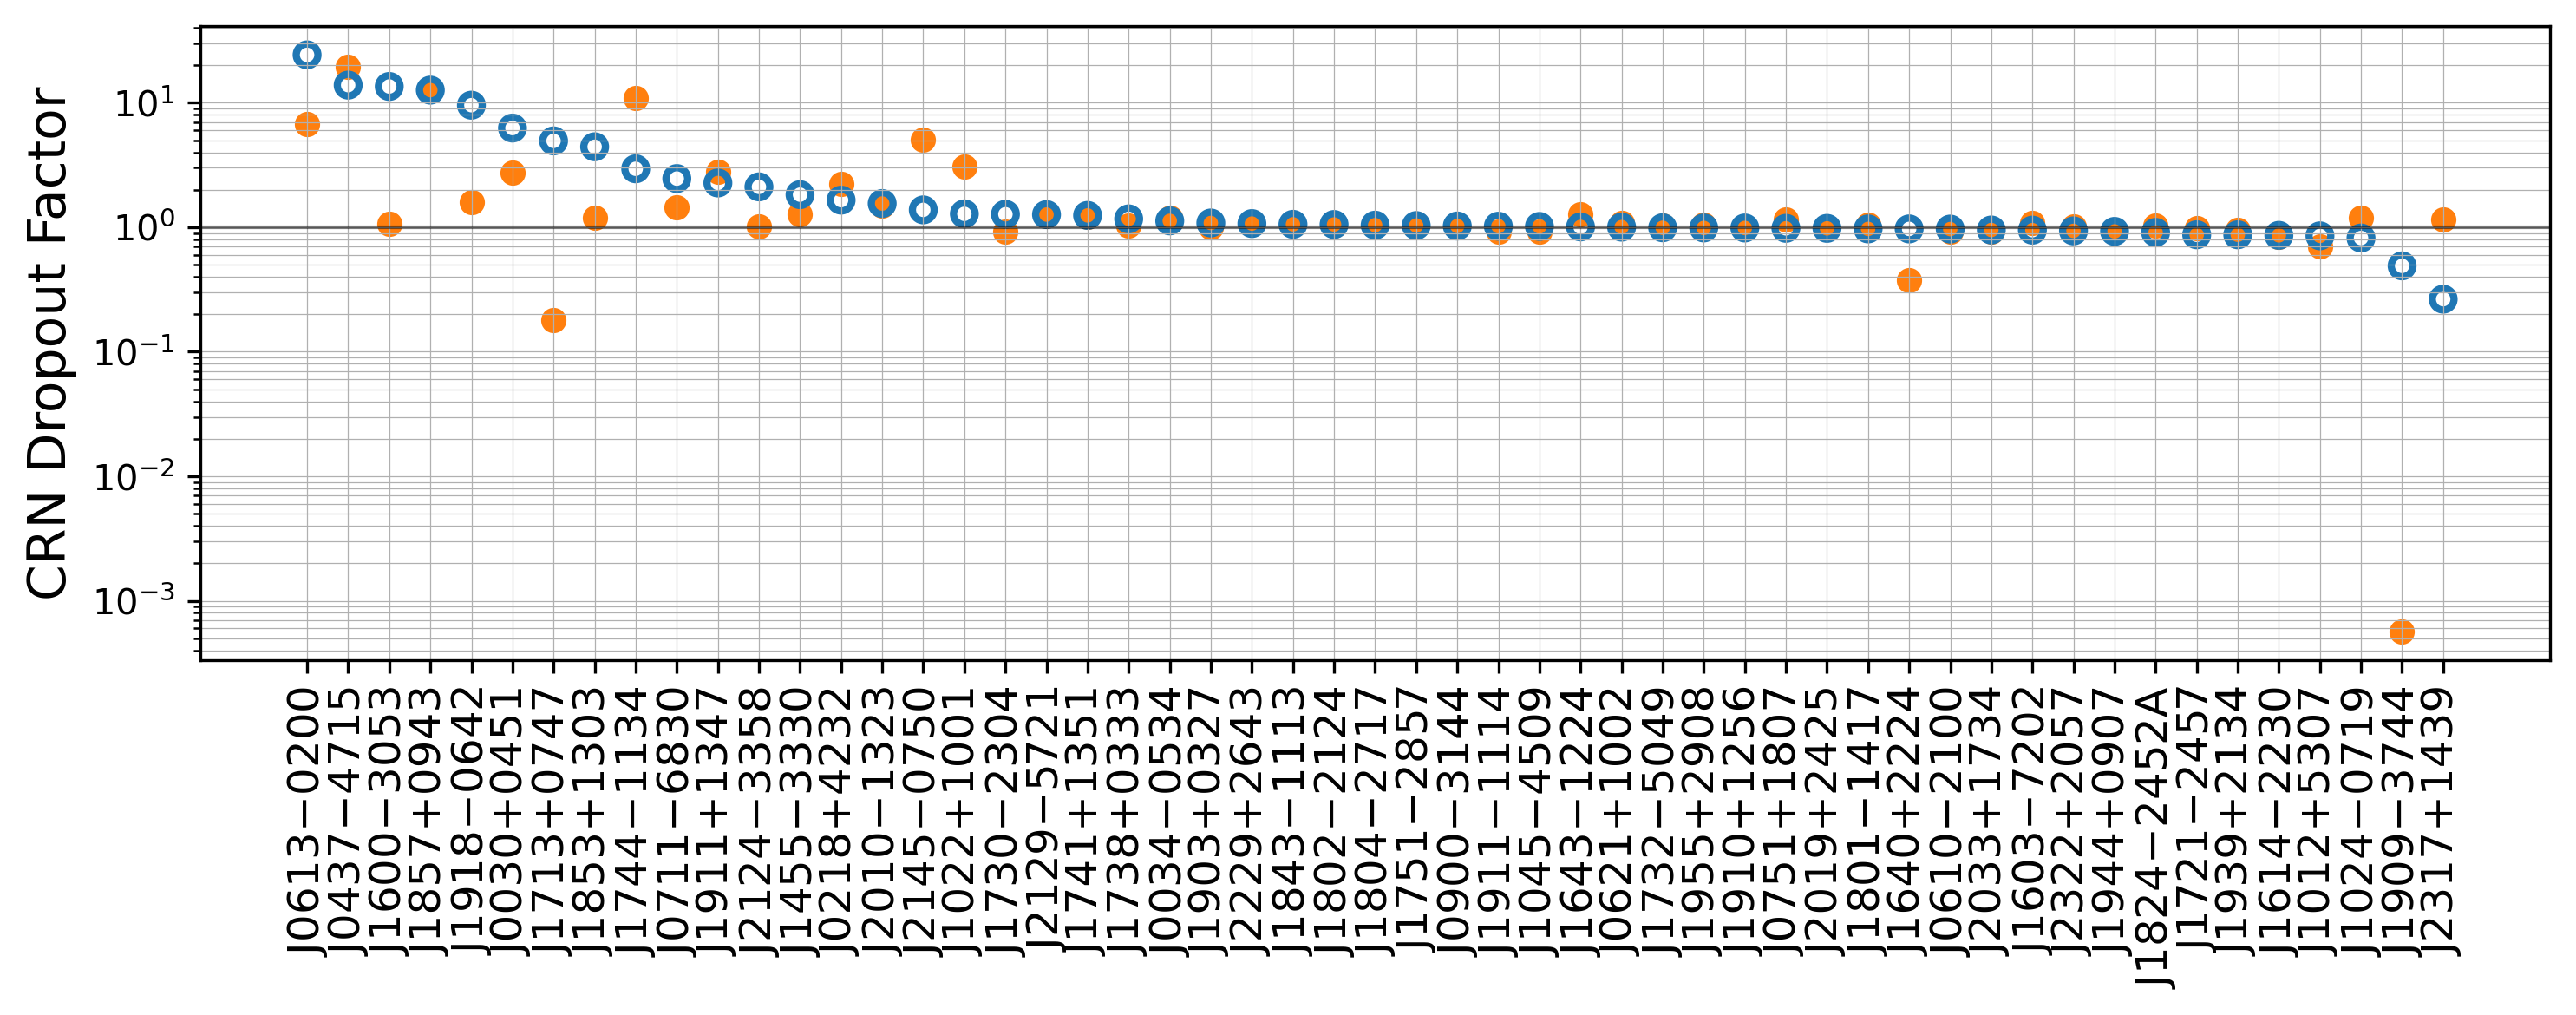

In [40]:
fig, ax = plt.subplots(figsize=(10,4),dpi=300)
ax.axhline(1, alpha=0.5, lw=1, color='k')
for i, psr_drop in enumerate(DFs['Full DR2']):
    ax.scatter([i], [DFs['DR2 Lite'][psr_drop]], color='C1')
    ax.scatter([i], [DFs['Full DR2'][psr_drop]], ec='C0', fc='none', lw=2)
ax.set_xticks(np.arange(len(FL_psrnames)))
ax.set_xticklabels(list(DFs['Full DR2'].keys()), rotation=90, fontsize='large')
ax.set_ylabel('CRN Dropout Factor', fontsize='x-large')
ax.semilogy()
ax.grid(which='both',lw=0.3)
fig.tight_layout()
fig.savefig(f'{figsave}/dropout.png', bbox_inches='tight', dpi=300)

It's important to compute uncertainties on the dropout factors. We can do this by following the procedure from the main paper to compute the uncertainty via bootstrapping.

For a given bootstrap realization, each individual pulsar’s MCMC chain was re-sampled with replacement. With the re-sampled CP posteriors for each pulsar, the factorized likelihood approach pieces together the dropout factor by iteratively removing pulsars from the array, and all by using bootstrapped pulsar CP posterior chains. This process was repeated for $10^3$ bootstrap realizations across $25$ different combinations of meta-parameters used in the factorized-likelihood dropout factor calculation. The end result is that the median dropout factor and 95 percent confidence intervals were computed from a total of $2.5 \times 10^4$ factorized likelihood dropout values for each pulsar.

Here are how we will change the meta-parameters:
- Number of FLike bins (61, 71, 81, 91, 101)
- Number of bins for Savage Dickey (6, 12, 18, 24, 30)

We will draw 1000 samples in every independent bootstrap realization. We will pre-compute the realizations as well.

In [12]:
# precompute bootstrap realizations
np.random.seed(3000)
n_samples_bootstrap = 1000
n_bootstraps = 1000
psr_masks = {}
for ds, lbl in zip(datasets, labels):
    psr_masks[lbl] = {}
    for psrname in FL_psrnames:
        psr_masks[lbl][psrname] = np.zeros((n_bootstraps,n_samples_bootstrap), dtype=int)
        s = sampler_dict[lbl][psrname]
        points, _, _ = s.posterior()
        for i in range(n_bootstraps):
            mask = np.random.choice(np.arange(len(points)), size=n_samples_bootstrap)
            psr_masks[lbl][psrname][i] = mask

In [13]:
from tqdm.contrib import itertools

In [14]:
datasets

['dr2lite_unfiltered', 'dr2full']

In [15]:
df_save_loc = '/vast/palmer/home.grace/bbl29/project/IPTA_DR2_analysis/dropout_factors'
Nbins_FLike_list = [61, 71, 81, 91, 101]
Nbins_SD_list = [6, 12, 18, 24, 30]
for ds, lbl in zip(datasets, labels):
    print(lbl)
    for psr_drop in tqdm.tqdm(FL_psrnames):
        if os.path.isfile(f'{df_save_loc}/{psr_drop}_{ds}.txt'):
            print(f'loading {ds} {psr_drop} from file')
            DFs_all[lbl][psr_drop] = np.loadtxt(f'{df_save_loc}/{psr_drop}_{ds}.txt')
        else:
            if not psr_drop in DFs_all[lbl]:
                DFs_all[lbl][psr_drop] = np.zeros(25000)
            # loop over meta-parameters & bootstrap realizations
            for i1, i2, i3 in itertools.product(range(5), range(5), range(1000), leave=False):
                i_tot = i1*5000 + i2*1000 + i3
                if DFs_all[lbl][psr_drop][i_tot] != 0:
                    continue
                DFs_all[lbl][psr_drop][i_tot] = compute_DF(psr_drop, sampler_dict[lbl], psrnames,
                                                           bootstrap_realizations=psr_masks[lbl],
                                                           bootstrap_idx=i3,
                                                           FLike_bin_num=Nbins_FLike_list[i1],
                                                           SD_nbins=Nbins_SD_list[i2])
            # save the DFs so we don't have to remake them
            np.savetxt(f'{df_save_loc}/{psr_drop}_{ds}.txt', DFs_all[lbl][psr_drop])

DR2 Lite


  9%|▉         | 5/53 [00:00<00:01, 41.16it/s]

loading dr2lite_unfiltered J0030+0451 from file
loading dr2lite_unfiltered J0034-0534 from file
loading dr2lite_unfiltered J0218+4232 from file
loading dr2lite_unfiltered J0437-4715 from file
loading dr2lite_unfiltered J0610-2100 from file
loading dr2lite_unfiltered J0613-0200 from file
loading dr2lite_unfiltered J0621+1002 from file
loading dr2lite_unfiltered J0711-6830 from file
loading dr2lite_unfiltered J0751+1807 from file


 28%|██▊       | 15/53 [00:00<00:00, 38.87it/s]

loading dr2lite_unfiltered J0900-3144 from file
loading dr2lite_unfiltered J1012+5307 from file
loading dr2lite_unfiltered J1022+1001 from file
loading dr2lite_unfiltered J1024-0719 from file
loading dr2lite_unfiltered J1045-4509 from file
loading dr2lite_unfiltered J1455-3330 from file
loading dr2lite_unfiltered J1600-3053 from file
loading dr2lite_unfiltered J1603-7202 from file


 43%|████▎     | 23/53 [00:00<00:00, 37.00it/s]

loading dr2lite_unfiltered J1614-2230 from file
loading dr2lite_unfiltered J1640+2224 from file
loading dr2lite_unfiltered J1643-1224 from file
loading dr2lite_unfiltered J1713+0747 from file
loading dr2lite_unfiltered J1721-2457 from file
loading dr2lite_unfiltered J1730-2304 from file
loading dr2lite_unfiltered J1732-5049 from file


 51%|█████     | 27/53 [00:00<00:00, 36.52it/s]

loading dr2lite_unfiltered J1738+0333 from file
loading dr2lite_unfiltered J1741+1351 from file
loading dr2lite_unfiltered J1744-1134 from file
loading dr2lite_unfiltered J1751-2857 from file
loading dr2lite_unfiltered J1801-1417 from file
loading dr2lite_unfiltered J1802-2124 from file


  0%|          | 0/25000 [00:00<?, ?it/s]

 58%|█████▊    | 31/53 [42:34<1:13:23, 200.15s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

 60%|██████    | 32/53 [1:25:10<2:33:03, 437.32s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

 62%|██████▏   | 33/53 [2:08:20<3:56:00, 708.04s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

 64%|██████▍   | 34/53 [2:50:25<5:11:49, 984.69s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

 66%|██████▌   | 35/53 [3:32:33<6:18:08, 1260.44s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 70%|██████▉   | 37/53 [4

  0%|          | 0/25000 [00:00<?, ?it/s]

 72%|███████▏  | 38/53 [5:38:45<8:02:52, 1931.52s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 74%|███████▎  | 39/53 [6:20:08<8:03:53, 2073.82s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

  0%|          | 0/25000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

  0%|          | 0/25000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

  0%|          | 0/25000 [00:00<?, ?it/s]

 19%|█▉        | 10/53 [2:51:21<16:35:38, 1389.27s/it]

loading dr2full J1012+5307 from file
loading dr2full J1022+1001 from file
loading dr2full J1024-0719 from file


  0%|          | 0/25000 [00:00<?, ?it/s]

 26%|██▋       | 14/53 [3:34:06<10:35:39, 977.95s/it] 

loading dr2full J1455-3330 from file
loading dr2full J1600-3053 from file


  0%|          | 0/25000 [00:00<?, ?it/s]

 32%|███▏      | 17/53 [4:16:43<9:18:52, 931.45s/it] 

  0%|          | 0/25000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 34%|███▍      | 18/53 [5:00:12<11:30:09, 1183.12s/it]

loading dr2full J1640+2224 from file
loading dr2full J1643-1224 from file
loading dr2full J1713+0747 from file


  0%|          | 0/25000 [00:00<?, ?it/s]

 42%|████▏     | 22/53 [5:43:03<8:02:23, 933.68s/it]  

  0%|          | 0/25000 [00:00<?, ?it/s]

 43%|████▎     | 23/53 [6:25:43<9:41:56, 1163.89s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

 45%|████▌     | 24/53 [7:08:18<11:15:33, 1397.71s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

 47%|████▋     | 25/53 [7:50:53<12:36:52, 1621.86s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

 49%|████▉     | 26/53 [8:33:33<13:41:22, 1825.27s/it]

loading dr2full J1744-1134 from file


  0%|          | 0/25000 [00:00<?, ?it/s]

 53%|█████▎    | 28/53 [9:16:12<11:13:36, 1616.65s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

 55%|█████▍    | 29/53 [9:58:51<12:07:27, 1818.65s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

 57%|█████▋    | 30/53 [10:41:21<12:42:58, 1990.35s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

loading dr2full J1857+0943 from file


  0%|          | 0/25000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

  0%|          | 0/25000 [00:00<?, ?it/s]

 91%|█████████ | 48/53 [21:14:22<3:20:44, 2408.95s/it]

  0%|          | 0/25000 [00:00<?, ?it/s]

 92%|█████████▏| 49/53 [21:59:49<2:46:25, 2496.46s/it]

loading dr2full J2145-0750 from file


  0%|          | 0/25000 [00:00<?, ?it/s]

 96%|█████████▌| 51/53 [22:45:20<1:06:38, 1999.16s/it]

loading dr2full J2317+1439 from file


  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 53/53 [23:30:49<00:00, 1597.16s/it]  


In [16]:
DFs_all

{'DR2 Lite': {'J0030+0451': array([ 2.46892874,  1.52872348,  1.46948532, ...,  0.96609625,
          1.02154713, 10.27828708]),
  'J0034-0534': array([0.81886256, 0.4514531 , 1.15581838, ..., 1.18433675, 0.86727176,
         1.13664722]),
  'J0218+4232': array([2.17707644, 1.54638936, 1.46517848, ..., 1.5450762 , 1.04859902,
         4.42255262]),
  'J0437-4715': array([10.88018734,  7.06458566,  1.96975088, ...,  1.40118132,
          2.54315256, 19.93336634]),
  'J0610-2100': array([0.75641316, 0.88981286, 0.95605734, ..., 1.01736717, 1.07399363,
         1.17746947]),
  'J0613-0200': array([ 3.63770876, 14.92145961,  2.43415117, ...,  2.72468701,
          4.7102196 ,  3.66226945]),
  'J0621+1002': array([1.14190599, 0.93076418, 0.81646931, ..., 1.2631031 , 1.00108062,
         0.94001394]),
  'J0711-6830': array([1.48463874, 1.17966276, 1.22216843, ..., 1.1351058 , 1.46310335,
         1.39174482]),
  'J0751+1807': array([1.4623491 , 0.98958523, 1.21634625, ..., 1.11791362, 1.2885

In [174]:
lbl

'DR2 lite'

In [17]:
for lbl in DFs_all:
    DFs_all[lbl] = {k.replace('-',r'$-$'): v for k, v in sorted(DFs_all[lbl].items(),
                                                                key=lambda item: np.nanmedian(item[1]),
                                                                reverse=True)}

In [18]:
DFs_all[lbl].items()

dict_items([('J0613$-$0200', array([36.16393587, 23.94960629, 22.19226634, ..., 25.28112261,
       25.17029214, 21.45703416])), ('J1600$-$3053', array([11.84850321, 12.84712718, 10.0146785 , ...,  6.32512786,
        7.48236806,  6.8240423 ])), ('J0437$-$4715', array([ 9.06728946, 12.05237745,  6.17890087, ...,  3.91890799,
        3.37600548,  6.5390965 ])), ('J1857+0943', array([11.25273085, 10.94549616, 10.44115379, ..., 11.20317137,
        3.65480559,  8.21225646])), ('J1918$-$0642', array([12.24527015,  7.66843928,  8.80539652, ...,  9.88609946,
       11.06795607,  7.86701193])), ('J1713+0747', array([ 9.00450624, 12.86568654,  8.98475868, ...,  7.45049766,
       13.43485991, 15.33313864])), ('J0030+0451', array([4.79996491, 5.35241453, 3.09354458, ..., 5.1062764 , 4.19144934,
       4.66941962])), ('J1744$-$1134', array([5.21820353, 4.46222321, 4.01734252, ..., 5.17764052, 3.49176756,
       3.39080689])), ('J1853+1303', array([3.97561485, 5.57108488, 3.08521603, ..., 2.29971

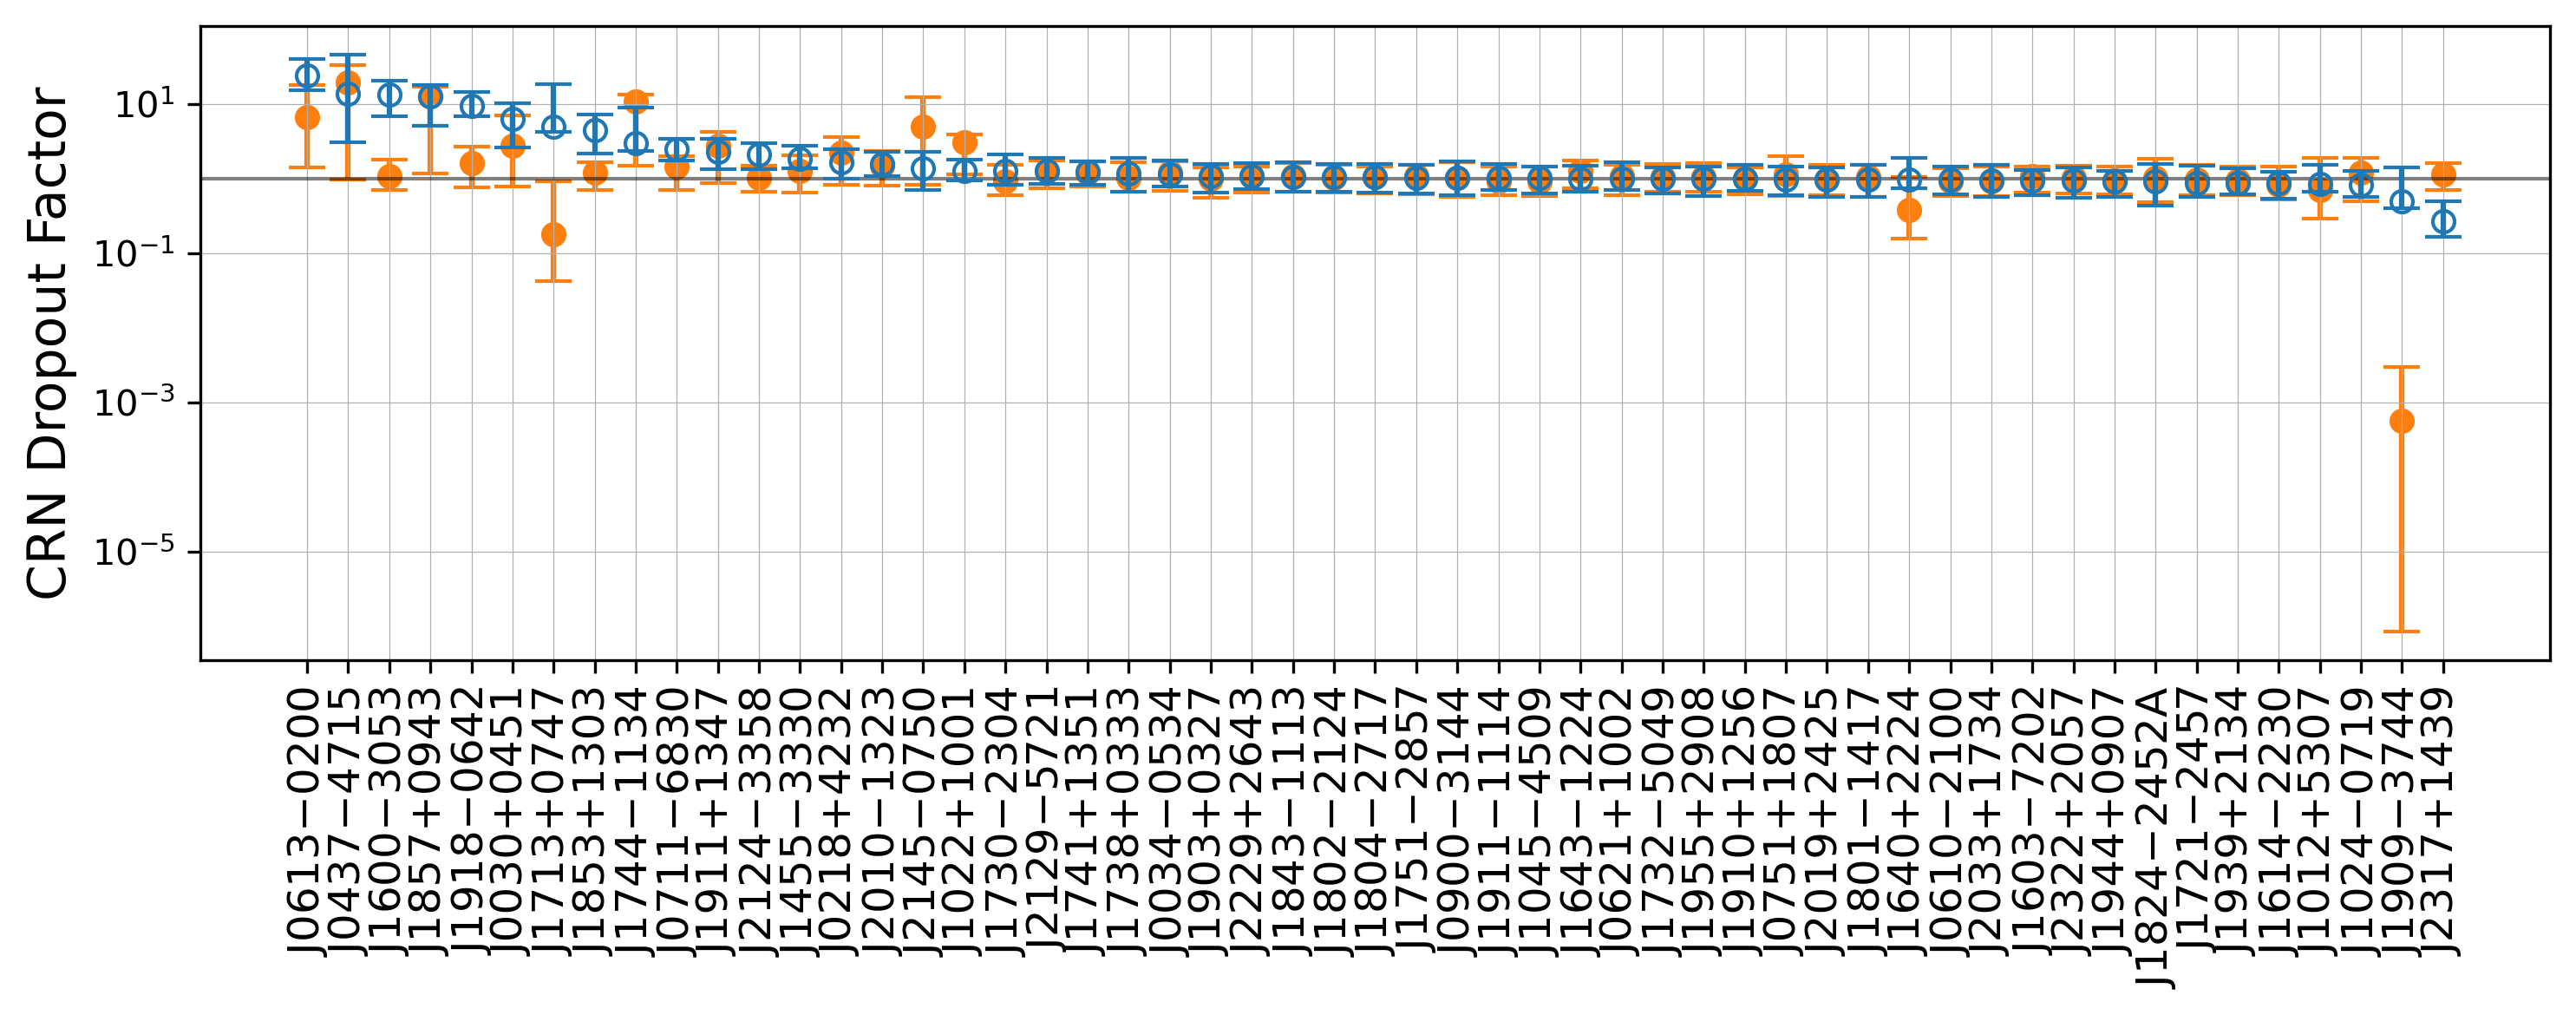

In [26]:
fig, ax = plt.subplots(figsize=(10,4),dpi=300)
ax.axhline(1, alpha=0.5, lw=1, color='k')
for i, psr_drop in enumerate(DFs['Full DR2']):
    # DR2 Lite
    DF = DFs['DR2 Lite'][psr_drop]
    yerr = DF - np.nanquantile(DFs_all['DR2 Lite'][psr_drop], [0.05,0.95])
    ax.errorbar(x=[i], y=[DF], yerr=np.abs(yerr[:,np.newaxis]), fmt=f'oC1', capsize=5, zorder=1)
    # Full DR2
    DF = DFs['Full DR2'][psr_drop]
    yerr = DF - np.nanquantile(DFs_all['Full DR2'][psr_drop], [0.05,0.95])
    ax.errorbar(x=[i], y=[DF], yerr=np.abs(yerr[:,np.newaxis]), fmt=f'oC0', mfc='none', capsize=5, zorder=2)
    #ax.scatter([i], [DFs['Full DR2'][psr_drop]], ec='C0', fc='none', lw=2)
ax.set_xticks(np.arange(len(FL_psrnames)))
ax.set_xticklabels(list(DFs['Full DR2'].keys()), rotation=90, fontsize='large')
ax.set_ylabel('CRN Dropout Factor', fontsize='x-large')
#if datastr == 'full' and litec:
#    ax.set_title(f'IPTA DR2litec CRN FL Dropout analysis', fontsize='x-large')
#else:
#    ax.set_title(f'IPTA DR2{datastr} CRN FL Dropout analysis', fontsize='x-large')
ax.semilogy()
ax.grid(which='both',lw=0.3)
fig.tight_layout()
fig.savefig(f'{figsave}/dropout_errors.png', bbox_inches='tight', dpi=300)

In [30]:
# what are the DFs and their uncertainties?
for psr_drop in DFs['Full DR2']:
    for lbl in labels:
        yerr = np.nanquantile(DFs_all[lbl][psr_drop], [0.05,0.95]) - DFs[lbl][psr_drop]
        print(psr_drop, lbl, f'{DFs[lbl][psr_drop]:0.4f}', f"[{yerr[0]:0.4f}, {yerr[1]:0.4f}]")

J0613$-$0200 DR2 Lite 6.7478 [-5.3341, 11.2079]
J0613$-$0200 Full DR2 24.2220 [-8.7913, 15.9151]
J0437$-$4715 DR2 Lite 19.5606 [-18.5845, 13.3612]
J0437$-$4715 Full DR2 13.8386 [-10.7807, 31.7472]
J1600$-$3053 DR2 Lite 1.0714 [-0.3625, 0.7003]
J1600$-$3053 Full DR2 13.5028 [-6.7117, 7.0921]
J1857+0943 DR2 Lite 12.5471 [-11.3708, 4.3233]
J1857+0943 Full DR2 12.6208 [-7.5295, 5.4103]
J1918$-$0642 DR2 Lite 1.5945 [-0.8334, 1.0507]
J1918$-$0642 Full DR2 9.5546 [-2.7154, 4.8692]
J0030+0451 DR2 Lite 2.7629 [-1.9764, 4.2646]
J0030+0451 Full DR2 6.2590 [-3.6481, 3.9242]
J1713+0747 DR2 Lite 0.1798 [-0.1377, 0.7341]
J1713+0747 Full DR2 4.9376 [-0.7200, 13.3399]
J1853+1303 DR2 Lite 1.1967 [-0.4994, 0.4464]
J1853+1303 Full DR2 4.4289 [-2.2642, 2.8755]
J1744$-$1134 DR2 Lite 10.8419 [-9.3492, 2.4314]
J1744$-$1134 Full DR2 2.9467 [-0.6233, 5.9011]
J0711$-$6830 DR2 Lite 1.4469 [-0.7358, 0.5722]
J0711$-$6830 Full DR2 2.4593 [-0.6936, 0.9620]
J1911+1347 DR2 Lite 2.7806 [-1.9028, 1.4228]
J1911+1347 Full 

In [197]:
np.nanquantile(DFs_all[lbl][psr_drop], [0.05,0.95])

array([0.1657564 , 0.49252549])

In [202]:
psrnames

array(['J0030+0451', 'J0034-0534', 'J0218+4232', 'J0437-4715',
       'J0613-0200', 'J0621+1002', 'J1012+5307', 'J1022+1001',
       'J1024-0719', 'J1455-3330', 'J1600-3053', 'J1640+2224',
       'J1643-1224', 'J1713+0747', 'J1744-1134', 'J1857+0943',
       'J1909-3744', 'J1918-0642', 'J1939+2134', 'J2145-0750',
       'J2317+1439'], dtype='<U10')

In [165]:
DF_med - np.quantile(DFs_all[lbl][psr_drop], [0.05,0.95])

array([ 0.33947296, -0.63315227])